## 7️⃣ Error Analysis


In [29]:
# Load libraries
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import pickle
import statsmodels.api as sm
import statsmodels.stats.diagnostic as ss
import scipy.stats as stats

# Import helper function made ad-hoc
# from R2_functions import univariate_outlier_removal
from R3_functions import chain_snap
from R4_functions import regression_report
from R7_functions import plot_residuals

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit, learning_curve

# Set random seed
np.random.seed(42)

**1.** Load the train and validation datasets used in section 5: 

Create a baseline model and carry out a data cleaning procedure based on the previous findings; 

In [2]:
DATA_TRAIN_PATH = os.path.join("data", "data_train_processed.parquet")
DATA_VAL_PATH = os.path.join("data", "data_val_processed.parquet")

In [5]:
data_dict = {}

for path in [DATA_TRAIN_PATH, DATA_VAL_PATH]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"File {path} not found")

    # Get key to store data in the dictionary and tailor the message
    key = "train" if "train" in path else "validation"

    print(f"Loading {key} data")

Loading train data
Loading validation data


In [6]:
# Load both train and validation data, apply the same processing,
# store them in a dictionary for later use
data_dict = {}

for path in [DATA_TRAIN_PATH, DATA_VAL_PATH]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"File {path} not found")

    # Get key to store data in the dictionary and tailor the message
    key = "train" if "train" in path else "validation"

    print(f"Loading {key} data")
    # Load data and process it
    df = (
        pd.read_parquet(path)
        # drop Address and Zipcode as they are not useful
        .drop(columns=["Address", "Zip"])
        # Drop Lat and Lon we will used the distance to the city center
        .drop(columns=["Lat", "Lon"])
        # Drop Delivery Area as it contains too many categories
        .drop(columns=["Delivery_area"])
        # Discard all the values Price > 2M
        .loc[lambda x: x.Price < 2e6]
        # double check nan values as sklearn does not like them
        .pipe(
            chain_snap,
            fn=lambda x: x.isna().sum().sum(),
            msg="Count NaNs post processing",
        )
        .pipe(chain_snap, fn=lambda x: x.shape, msg="Size dataframe")
        .pipe(chain_snap, fn=lambda x: display(x.head(2)), msg=f"{key} data head")
    )

    # store data in a dictionary
    data_dict[key] = df


# unpack data
df_train = data_dict["train"]
df_val = data_dict["validation"]

Loading train data
Count NaNs post processing: 0
Size dataframe: (543, 15)


,Price,Area,Room,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
0,635000.0,81.0,3.0,13.36138,4.394449,1.098612,1078,0,7,8,27.0,3.295837,3.317122,3.346089,0.031533
1,400000.0,61.0,2.0,12.89922,4.110874,0.693147,1057,0,5,7,30.5,3.417727,1.947822,2.348155,0.036792


train data head: None
Loading validation data
Count NaNs post processing: 0
Size dataframe: (181, 15)


,Price,Area,Room,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
0,425000.0,68,3,12.959844,4.219508,1.098612,1098,0,9,8,22.666667,3.120895,3.606198,4.174069,0.071974
1,285000.0,96,4,12.560244,4.564348,1.386294,1104,1,0,4,24.000000,3.178054,7.350449,8.209335,0.135124


validation data head: None


**2.** Load the best estimator which has been stored as a pickle file. 

In [7]:
FEATURES_CANDIDATE = [
    "log(Area)",
    "log(Room)",
    "log(AR-ratio)",
    "Manhattan_distance",
    "Region",
    "Location",
]
TARGET = "Price"  # we don't consider the log of the price as we will compare with the original price

In [8]:
# Get list of folder in artifacts
print(os.listdir("artifacts"))

['2024-03-30-15-35-49_Ridge', '.DS_Store', '2024-03-30-15-22-49_Ridge', '2024-01-11-08-37-12_baseline_model', '2024-01-15-18-42-23_Ridge']


In [9]:
# Load Candidate model and its corresponding performance table
CANDIDATE_PATH = os.path.join("artifacts", "2024-03-30-15-35-49_Ridge")
MODEL_PATH = os.path.join(CANDIDATE_PATH, "Ridge.pkl")
candidate_model = pickle.load(open(MODEL_PATH, "rb"))
display(candidate_model)

# import model performance table
REPORT_PATH = os.path.join(CANDIDATE_PATH, "ridge_performance.csv")
df_performance_candidate = pd.read_csv(REPORT_PATH, index_col=0)
display(df_performance_candidate)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['log(Area)', 'log(Room)',
                                                   'log(AR-ratio)',
                                                   'Manhattan_distance']),
                                                 ('nom',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Region', 'Location'])])),
                ('Ridge', Ridge(alpha=0.2535151515151515))])

,metrics,in-sample,out-of-sample,Difference (%),Description
model,,,,,
Ridge,r-squared,0.840,0.777,-8.108108,Coefficient of Determination
Ridge,explained variance,0.841,0.783,-7.407407,Explained Variance Score
Ridge,RMSE,127800.591,160521.179,20.383969,Root Mean Squared Error (RMSE)
Ridge,MAE,76344.930,93887.806,18.684936,Mean Absolute Error (MAE)
Ridge,max error,942098.599,1031360.528,8.654775,The maximum residual error


**Case: Regression problem**

When dealing with a regression problem, one should analyse the residuals, which are the difference between the predicted and observed values of the dependent variable (target) and subsequently:

**•** Plot the residuals versus the fitted values, and determine qualitatively any phenomenon of [heteroskedasticity](https://www.displayr.com/what-is-heteroscedasticity/#:~:text=The%20most%20widely%20used%20test,used%20in%20the%20original%20model.)

🧑‍🔬 To get a quantitative assessment of heteroskedasticity use the [*Breusch-Pagan test*](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html).

In [10]:
# loop through dataframes
for key, df in data_dict.items():
    print(f"Computing residuals for {key} data")
    # compute predictions
    y_pred = np.exp(candidate_model.predict(df[FEATURES_CANDIDATE]))
    # compute residuals
    residuals = df[TARGET] - y_pred
    # store predictions and residuals in dataframe
    df["y_pred"] = y_pred
    df["residuals"] = residuals
    # print out the updated dfs with predictions and residuals
    display(df.head().round(3))

Computing residuals for train data


,Price,Area,Room,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance,y_pred,residuals
0,635000.0,81.0,3.0,13.361,4.394,1.099,1078,0,7,8,27.000,3.296,3.317,3.346,0.032,657362.162,-22362.162
1,400000.0,61.0,2.0,12.899,4.111,0.693,1057,0,5,7,30.500,3.418,1.948,2.348,0.037,456822.940,-56822.940
2,695000.0,88.0,3.0,13.452,4.477,1.099,1053,0,5,3,29.333,3.379,1.226,1.430,0.025,647048.593,47951.407
3,1050000.0,119.0,5.0,13.864,4.779,1.609,1075,0,7,5,23.800,3.170,2.846,3.146,0.053,888404.921,161595.079
4,300000.0,54.0,2.0,12.612,3.989,0.693,1055,0,5,5,27.000,3.296,2.922,3.370,0.057,394687.897,-94687.897


Computing residuals for validation data


,Price,Area,Room,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance,y_pred,residuals
0,425000.0,68,3,12.960,4.220,1.099,1098,0,9,8,22.667,3.121,3.606,4.174,0.072,463212.431,-38212.431
1,285000.0,96,4,12.560,4.564,1.386,1104,1,0,4,24.000,3.178,7.350,8.209,0.135,350322.899,-65322.899
2,270000.0,84,3,12.506,4.431,1.099,1106,1,0,6,28.000,3.332,9.243,10.090,0.158,297404.777,-27404.777
3,450000.0,53,2,13.017,3.970,0.693,1051,0,5,1,26.500,3.277,1.442,1.590,0.027,411364.437,38635.563
4,549000.0,101,4,13.216,4.615,1.386,1031,0,3,1,25.250,3.229,1.922,2.005,0.030,542723.137,6276.863


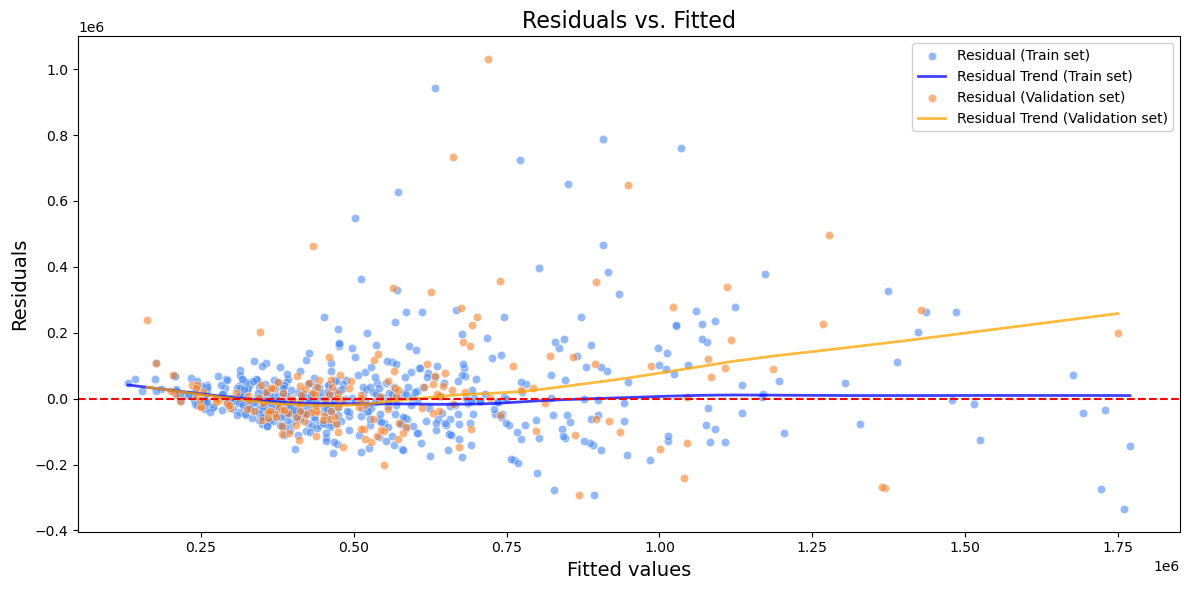

In [11]:
warnings.filterwarnings("ignore")
from matplotlib import ticker 

fig, ax = plt.subplots(figsize=(12, 6))

# Set line width and transparency
lw = 2
alpha = 0.75

# Define colors for each dataset
train_color = '#4C8BF5'
validation_color = '#F9812A'

# Loop through data and plot
for key, df in data_dict.items():
    if key == "train":
        scatter_color = train_color
        line_color = "blue"
        label_residuals = "Residual (Train set)"
        label_trend = "Residual Trend (Train set)"
    elif key == "validation":
        scatter_color = validation_color
        line_color = "orange"
        label_residuals = "Residual (Validation set)"
        label_trend = "Residual Trend (Validation set)"
    else:
        raise ValueError(f"Unknown key {key}")

    # Scatter plot
    sns.scatterplot(
        x=df["y_pred"],
        y=df["residuals"],
        color=scatter_color,
        alpha=0.6,
        label=label_residuals,
        ax=ax,
    )

    # Generate trend lines
    sns.regplot(
        x=df["y_pred"],
        y=df["residuals"],
        scatter=False,
        lowess=True,
        line_kws={"color": line_color, "lw": lw, "alpha": alpha},
        ax=ax,
        label=label_trend,
    )

# Add horizontal line for reference at y=0
ax.axhline(0, color="red", linestyle="--", linewidth=1.5)

# Customize plot
ax.set_title("Residuals vs. Fitted", fontsize=16)
ax.set_xlabel("Fitted values", fontsize=14)
ax.set_ylabel("Residuals", fontsize=14)


# Add legend
ax.legend(loc="upper right", frameon=True, framealpha=0.9)

# Show plot
plt.tight_layout()
plt.show()


# Show the plot
plt.show()


**•** Plot the distribution of the residuals and measure the mean and the residual standard error. Contextualize these values and assess if they are acceptable using business knowledge.

In [12]:
# Initialize an empty DataFrame to store results
df_res = pd.DataFrame()

# Loop through the df and compute the mean and standard deviation of residuals
for key, df in data_dict.items():
    # Scale residuals to thousands and compute mean and std
    res = (
        df.assign(residuals=lambda x: x["residuals"] / 1000)  # Scale residuals
        .agg({"residuals": ["mean", "std"]})  # Compute mean and std
        .rename(columns={"residuals": f"residuals_{key}"})  # Rename columns for each set
    )
    
    # Concatenate results
    df_res = pd.concat([df_res, res], axis=1)

print("Residual Statistics (in k€):")
# Format values as k€ and display
display( df_res.style.format("{:,.1f} k€"))


Residual Statistics (in k€):


,residuals_train,residuals_validation
mean,11.6 k€,27.4 k€
std,127.4 k€,158.6 k€


***Intrerpretation of the mean, residual standard error***
- When the model is correctly specified, the mean value of residuals should be zero
- *The **mean value** of the residual indicates whether the model yields a systematic overestimation (negative value) or underestimation (positive value) on its prediction.*
- *The **residual standard error** is the average amount of actual values differing from the model's predictions.* 

For the candidate model, we would expect that we would estimate the price of a house with on average 28k€ less than the actual value and with 68% of the predicted price will be $\pm$ 159k€ (note: 68% is because we assume the residual normally distributed hence 68% of the data is roughly one standard deviation from the average). 

*For example, for a hypothetical house with an Area of 100 $m^{2}$, 5 Rooms, 0.15 distant from the centre expressed in Manhattan_distance, located in Region 1 and location 0, the candidate model predicts*:

In [13]:
# Get results based on example provided above
sample = pd.DataFrame(
    data={
        "log(Area)": np.log(100),
        "log(Room)": np.log(5),
        "log(AR-ratio)": np.log(100 / 5),
        "Manhattan_distance": 0.15,
        "Region": 1,
        "Location": 0,
    },
    index=[0],
)

# express prices in k€
house_price_estimation = np.exp(candidate_model.predict(sample))[0] / 1e3
mean_residual = df_val["residuals"].mean() / 1e3
std_residual = df_val["residuals"].std() / 1e3

print(
    f"""The estimated price for the sample is {house_price_estimation:.0f} k€ 
with 68% of chance of having the true value between {house_price_estimation + mean_residual - std_residual:.0f} k€ and {house_price_estimation + mean_residual + std_residual:.0f} k€."""
)

The estimated price for the sample is 354 k€ 
with 68% of chance of having the true value between 222 k€ and 539 k€.


*This example showed that such a prediction would not be useful, as the uncertainty range is too high.* 

- Check high residual values, which indicate a poor prediction, and try to spot any pattern by analyzing the corresponding input values. Investigate the distribution of the model input (features) and apply statistical tests by comparing outliers versus non-outlier values.

In [18]:
# Select which residuals to plot among 'train' and 'validation' sets 
key = "validation"  # options are 'train' or 'validation

# focus only on the validation set
df_plot = df_val.copy()
plot_stast = df_plot["residuals"].describe()

# compute summary statistics to visualize on the plot
s_stast = pd.concat(
    [
        df_plot["residuals"]
        # get summary statistics
        .describe()
        # divide by 1000 to get k€
        .apply(lambda x: x / 1000)
        # round to 1 decimal
        .round(1)
        # drop count as it is not useful
        .drop("count"),
        # re-add count at the end of the series
        pd.Series(df_plot["residuals"].count(), index=["count"]),
    ]
)

print(f"o Show summary statistics in {key} data")
display(s_stast.to_frame().T)

o Show summary statistics in validation data


,mean,std,min,25%,50%,75%,max,count
0,27.4,158.6,-293.1,-46.5,1.0,53.4,1031.4,181.0


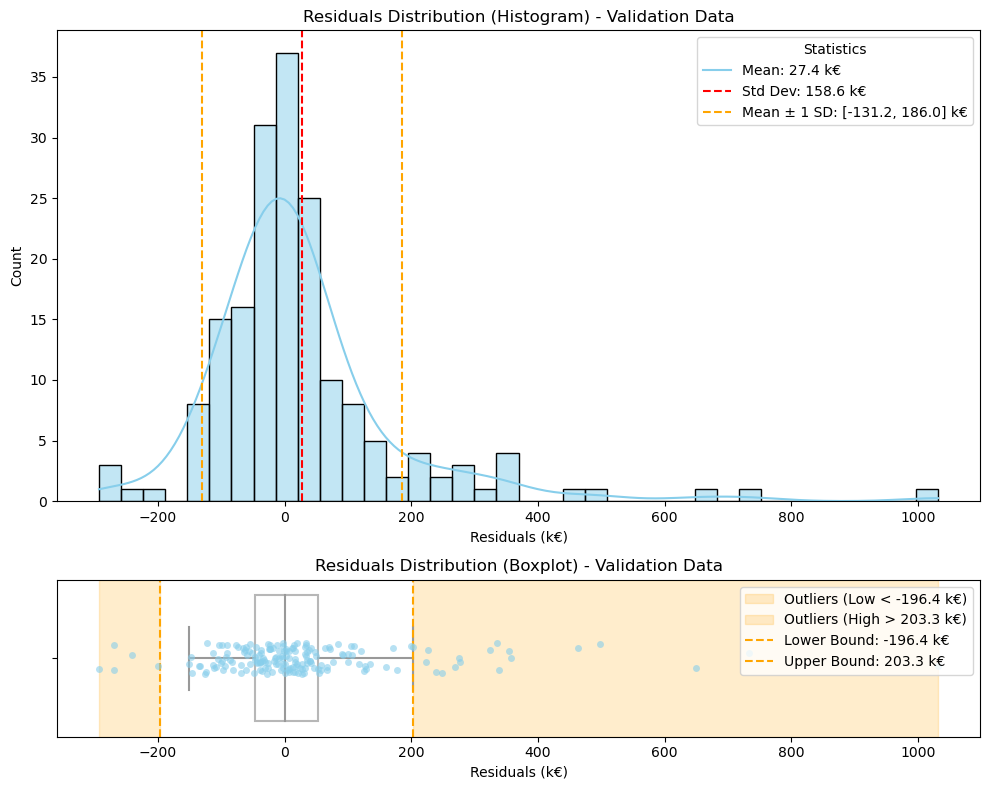

In [35]:
#PLOT RESIDUALS DISTRIBUTION in both as histogram and boxplot
plot_residuals(data_dict, dataset_key="validation")  # options are 'train' or 'validation'


- The above visualisation showed that the residuals are not normally distrubuted, due to a heavy right skew. 

In [38]:
# Let us create a new variable called `outliers` that flags `True` outliers based on the IQR method

# Calculate IQR and thresholds for outliers
q1 = df_val["residuals"].quantile(0.25)
q3 = df_val["residuals"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Create a DataFrame for error analysis
df_error_analysis = (
    df_val
    .assign(
        # Identify outliers based on residual thresholds
        outliers=lambda x: (x["residuals"] < lower_bound) | (x["residuals"] > upper_bound),
        # Convert Price and residuals to thousands of euros and round residuals
        Price=lambda x: x["Price"] / 1000,
        residuals=lambda x: round(x["residuals"] / 1000, 1)
    )
    # Select only the relevant columns
    .loc[:, ["Price", "Area", "Room", "Manhattan_distance", "residuals", "outliers"]]
    .sort_values(by="residuals", ascending=True)
)

# Display outliers
display(df_error_analysis.loc[df_error_analysis["outliers"]])

# Store summary information
num_samples = len(df_error_analysis)
num_outliers = df_error_analysis["outliers"].sum()
percentage_outliers = (num_outliers / num_samples) * 100

print("• Price and Residuals are in k€")
print(f"• Number of samples in validation set = {num_samples}")
print(f"• Absolute number of outliers in validation set = {num_outliers}")
print(f"• Percentage of outliers in validation set = {percentage_outliers:.2f}%")

,Price,Area,Room,Manhattan_distance,residuals,outliers
83,575.0,183,5,0.058278,-293.1,True
107,1099.0,191,6,0.044197,-270.0,True
158,1095.0,204,6,0.022995,-269.3,True
184,799.0,146,5,0.063903,-241.0,True
117,350.0,110,5,0.063693,-199.8,True
163,915.0,88,5,0.010290,222.4,True
149,1495.0,175,6,0.010027,226.9,True
102,400.0,25,2,0.079482,238.2,True
97,950.0,94,1,0.027149,248.8,True
93,1698.0,205,5,0.053619,269.6,True


• Price and Residuals are in k€
• Number of samples in validation set = 181
• Absolute number of outliers in validation set = 22
• Percentage of outliers in validation set = 12.15%


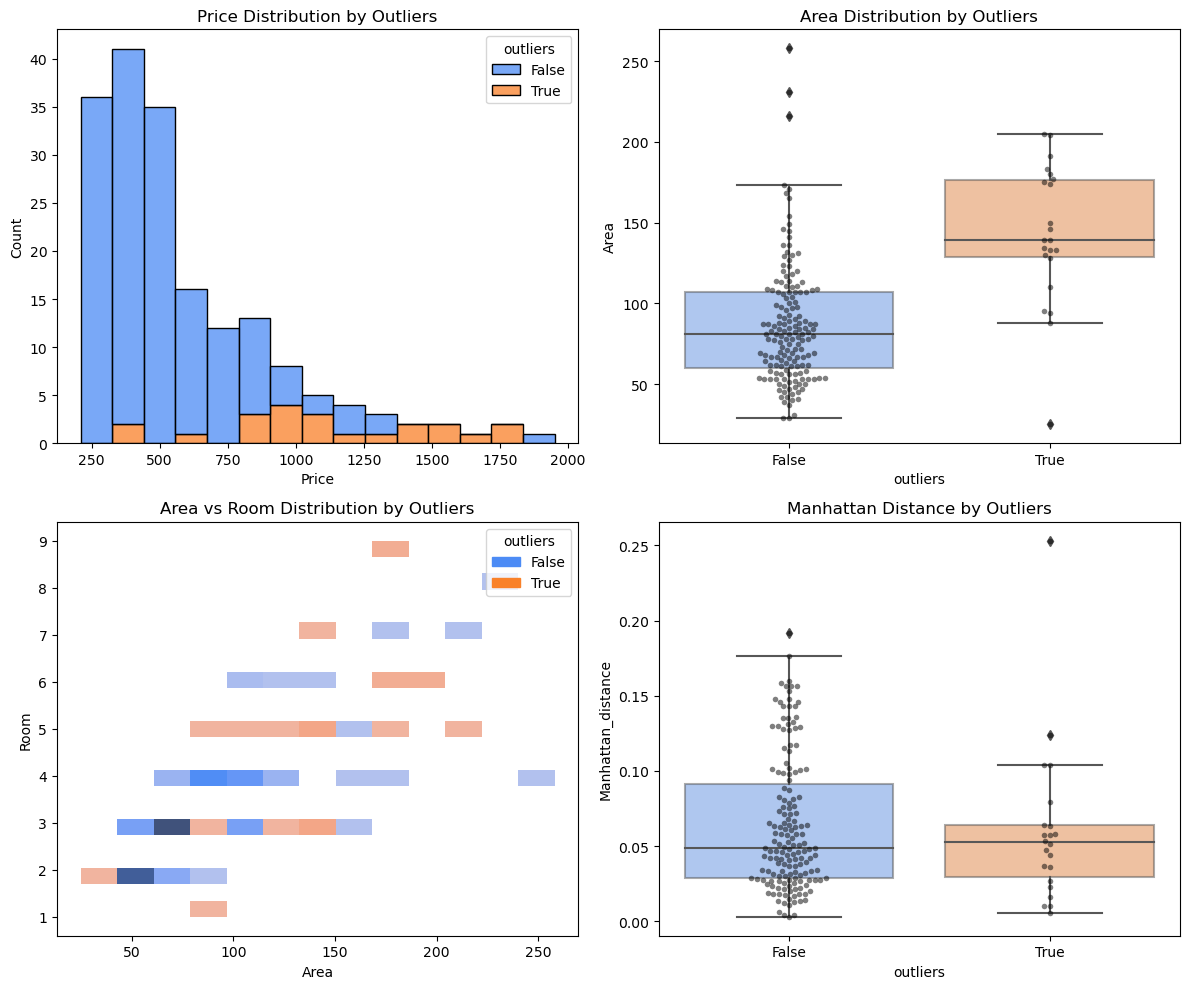

In [ ]:
# Define custom palette for outliers
palette = ["#4C8BF5", "#F9812A"]  # Blue for non-outliers, Orange for outliers

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# 1. Histogram of Price grouped by outliers
sns.histplot(
    data=df_error_analysis,
    x="Price",
    hue="outliers",
    multiple="stack",
    palette=palette,
    ax=axs[0, 0]
)
axs[0, 0].set_title("Price Distribution by Outliers")

# 2. Boxplot and swarmplot of Area grouped by outliers
sns.boxplot(
    data=df_error_analysis,
    y="Area",
    x="outliers",
    palette=palette,
    ax=axs[0, 1],
    boxprops=dict(alpha=0.5)
)
sns.swarmplot(
    data=df_error_analysis,
    y="Area",
    x="outliers",
    color="black",
    size=4,
    alpha=0.5,
    ax=axs[0, 1]
)
axs[0, 1].set_title("Area Distribution by Outliers")

# 3. Histogram of Area vs Room grouped by outliers
sns.histplot(
    data=df_error_analysis,
    x="Area",
    y="Room",
    hue="outliers",
    palette=palette,
    ax=axs[1, 0]
)
axs[1, 0].set_title("Area vs Room Distribution by Outliers")

# 4. Boxplot and swarmplot of Manhattan_distance grouped by outliers
sns.boxplot(
    data=df_error_analysis,
    y="Manhattan_distance",
    x="outliers",
    palette=palette,
    ax=axs[1, 1],
    boxprops=dict(alpha=0.5)
)
sns.swarmplot(
    data=df_error_analysis,
    y="Manhattan_distance",
    x="outliers",
    color="black",
    size=4,
    alpha=0.5,
    ax=axs[1, 1]
)
axs[1, 1].set_title("Manhattan Distance by Outliers")


plt.tight_layout()
plt.show()

In [42]:
print("• Summary statistics of variables which appear driving the outliers")
display(df_error_analysis.loc[df_error_analysis["outliers"] == True, ["Price", "Area", "Room"]].describe().round(1).T)

• Summary statistics of variables which appear driving the outliers


,count,mean,std,min,25%,50%,75%,max
Price,22.0,1122.0,408.5,350.0,903.0,1095.0,1436.2,1775.0
Area,22.0,142.4,43.4,25.0,128.5,139.0,176.5,205.0
Room,22.0,4.9,2.0,1.0,3.0,5.0,6.0,9.0


<!-- **Final assessment**

**•** Summarize the findings and, if necessary, retrain a new model based on the new knowledge from the error analysis. -->


**Summary Error Analysis**

Based on the analysis carried out above, we found that: 
- 12.15% of samples in the validation  (i.e.,22 out of 181 ) are flagged as outliers based on the IQR method: 
    - 75% of the outliers having Price above 903k€ 
    - Outliers have an average Area = 142.4 $m^{2}$.
    - The distance from the center does not influence outliers.
- A high price tends to have a higher chance of unacceptable prediction error. The same can be applied for Area as it strongly correlates with Price.
    - Most outliers start from a price of 903 K€ and 128.5 $m^{2}$, the 25% quantile of the Price and Area respectively. 
- Room=1 and Room=9 are very few samples, flagged outliers in all cases. We also found before that Room strongly correlates with Area and Price.

- One sample has Room = 1 with a Price of 950k€ and 94 $m^{2}$; this example is rather peculiar as Dutch houses do generally not have such a high square meter per room. The same consideration can be made for two other samples with Room=9. These samples are expected to be extremely difficult to estimate with the current data. Furthermore, a significant amount is considered as an outlier when Room=5; hence, one can consider restricting the input range of **2 <= Room <= 4** to have reasonable accuracy.  


Given the current findings, we may want to consider the impact of outliers affecting the accuracy of the model, and one should consider re-train the model after removing them. 

Let's analyze the current model performance separately for:
- Expected range with **good** model performance: $Area \leq 128.5 m^2$ AND $2 \leq Room \leq 4$
- Expected range with **poor** model performance: *else*

In [70]:
# Candidate Model Performance for All Samples
print("Candidate Model performance for all samples in validation set:")
full_performance = regression_report(y_true=df_val["Price"], y_pred=df_val["y_pred"])
display(full_performance)

# Filter Data: Good Range
df_good_range = df_val.loc[
    lambda x: (x["Area"] <= 128) & (x["Room"] >= 2) & (x["Room"] <= 4)
]


print("\nCandidate Model performance with restricted range in validation set [expected to be better]:")
good_range_performance = regression_report(
    y_true=df_good_range["Price"], 
    y_pred=df_good_range["y_pred"]
)
display(good_range_performance)
print(f"• Number of samples in good model performance range = {len(df_good_range)}")

# Filter Data: Bad Range
df_bad_range = df_val.loc[~df_val.index.isin(df_good_range.index)]

# Ensure the lengths of the datasets match
assert len(df_val) == len(df_good_range) + len(df_bad_range), "Dataframe length mismatch!"

print("\nCandidate Model performance with restricted range in validation set [expected to be worse]:")
bad_range_performance = regression_report(
    y_true=df_bad_range["Price"], 
    y_pred=df_bad_range["y_pred"]
)
display(bad_range_performance)
print(f"• Number of samples in bad model performance range = {len(df_bad_range)}")

Candidate Model performance for all samples in validation set:


,Score,Description
r-squared,0.777,Coefficient of Determination
explained variance,0.783,Explained Variance Score
RMSE,160521.179,Root Mean Squared Error (RMSE)
MAE,93887.806,Mean Absolute Error (MAE)
max error,1031360.528,The maximum residual error



Candidate Model performance with restricted range in validation set [expected to be better]:


,Score,Description
r-squared,0.782,Coefficient of Determination
explained variance,0.783,Explained Variance Score
RMSE,79906.248,Root Mean Squared Error (RMSE)
MAE,55641.344,Mean Absolute Error (MAE)
max error,462275.345,The maximum residual error


• Number of samples in good model performance range = 131

Candidate Model performance with restricted range in validation set [expected to be worse]:


,Score,Description
r-squared,0.564,Coefficient of Determination
explained variance,0.635,Explained Variance Score
RMSE,276673.082,Root Mean Squared Error (RMSE)
MAE,194093.538,Mean Absolute Error (MAE)
max error,1031360.528,The maximum residual error


• Number of samples in bad model performance range = 50


<!-- To minimize the prediction error across the entire price range up to 2M€ one can attempt to train two models:
- one model which is trained on a subset of the feature range, namely **Area <= 128 & 2 <= Room <= 4**.
- a second model with a **complementary range or Room > 4**.

Combine both models via a look-up table with *Area* and *Room* as selectors. -->

- Generate the [learning curve](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/) to graphically represents the model's learning performance changes as the number of samples increases and assess if the model is underfitting, overfitting, or well-fitting .   

    - Learning curves can be used to diagnose if datasets are not representative of the problem domain.

- Finally, use this plot to evaluate whether collecting additional data can increare the model performance.

    - Collecting additional data can sometimes improve the performance of a machine learning model. However, there are cases where adding more data may not necessarily lead to better performance.


/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/Anacoda/lib/python3.

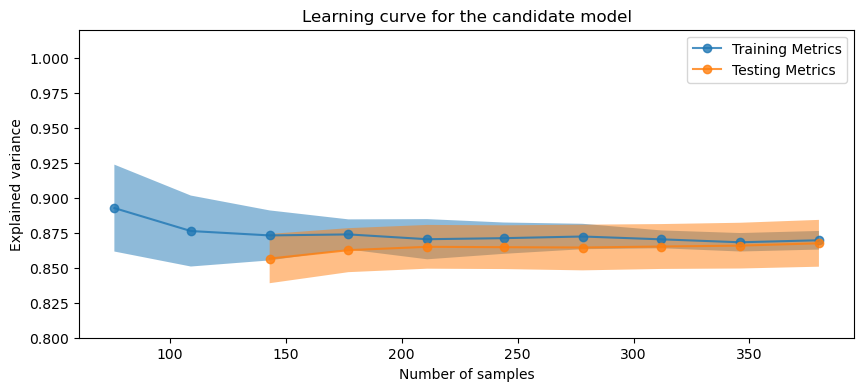

In [61]:
# Define learning curve parameters
learning_curve_params = {
    "X": df_train[FEATURES_CANDIDATE],          # provide the features
    "y": df_train["log(Price)"],                # provide the target
    "train_sizes": np.linspace(0.2, 1.0, 10),   # provide the train sizes (20% to 100%)
    "cv": ShuffleSplit(n_splits=10, test_size=0.3, random_state=42),  #provide the cross-validation strategy
    "scoring": "explained_variance",            # Scoring metric
    "n_jobs": -1,                               # Use all CPU cores
    "line_kw": {"marker": "o", "alpha": 0.8},   # Plot appearance
    "std_display_style": "fill_between",        # provide the style for the standard deviation
}

# Create and plot learning curve
fig, ax = plt.subplots(figsize=(10, 4))
LearningCurveDisplay.from_estimator(
    candidate_model,
    **learning_curve_params,
    ax=ax
)

# Customize the legend labels
handles, labels = ax.get_legend_handles_labels()                         # Get the current legend handles and labels
ax.legend(handles, ["Training Metrics", "Testing Metrics"], loc="best")  # Update labels


ax.set_title("Learning curve for the candidate model")
ax.set_xlabel("Number of samples")
ax.set_ylabel("Explained variance")
ax.set_ylim(0.8, 1.02)  # adjust ylimit

plt.show()

- **Train Score**: as observed by the blue trend line, the train model performs well with a small number of samples. The decline in training score when the model is exposed to more data suggests that it's less able to fit the training set perfectly, likely due to increasing variance in the data.
- **Cross Validation Score**: as can be observed by the orange line, it starts low but shows gradual increase when sample size increases, which is a good sign of generalisability. However, the gap between the two lines indicates that the training model is likely to overfit the train data, one could remove outliers in train set and observe the model performance change 
- **Converging Trend**: this indicates adding more data could improve model generalisability,and that the model is learning effectively. The plateau trend also indicated there is no meaningful improvement of model performance when sample size increases. One could add more data to training set, and continuously track the CV score. Further improvement may require feature engineering or a more expressive model.

In [66]:
# Complexity analysis
complexity_analysis_params = {
    "X": df_train[FEATURES_CANDIDATE],
    "y": df_train["log(Price)"],
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=50, test_size=0.3, random_state=42),
    "n_jobs": -1,
    "return_times": True,
}

train_sizes, _, test_scores, fit_times, score_times = learning_curve(
    candidate_model, **complexity_analysis_params
)


/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/pipeline.py", line 749, in score
    Xt = transform.transform(Xt)
  File "/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", lin

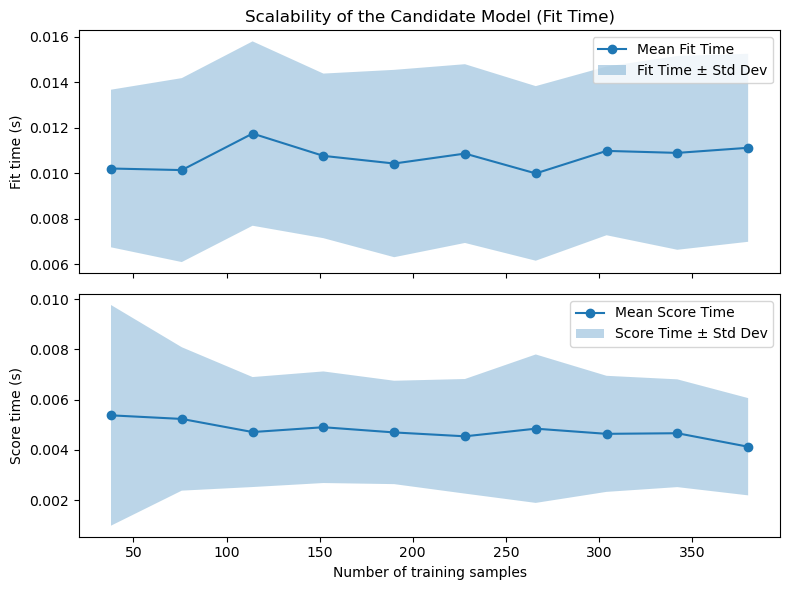

In [68]:
# Create subplots for scalability analysis
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)

# Plot scalability for fit time
axes[0].plot(train_sizes, fit_times.mean(axis=1), "o-", label="Mean Fit Time")
axes[0].fill_between(
    train_sizes,
    fit_times.mean(axis=1) - fit_times.std(axis=1),
    fit_times.mean(axis=1) + fit_times.std(axis=1),
    alpha=0.3,
    label="Fit Time ± Std Dev"
)
axes[0].set_ylabel("Fit time (s)")
axes[0].set_title("Scalability of the Candidate Model (Fit Time)")
axes[0].legend()

# Plot scalability for score time
axes[1].plot(train_sizes, score_times.mean(axis=1), "o-", label="Mean Score Time")
axes[1].fill_between(
    train_sizes,
    score_times.mean(axis=1) - score_times.std(axis=1),
    score_times.mean(axis=1) + score_times.std(axis=1),
    alpha=0.3,
    label="Score Time ± Std Dev"
)
axes[1].set_ylabel("Score time (s)")
axes[1].set_xlabel("Number of training samples")
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

<!-- - **Fit Time Plot**: The fit time increases predictably as the number of training samples grows, indicating the model scales linearly with data size. The small variation across folds suggests stable and consistent training performance.
- **Score Time Plot**: The score time remains very low and stable across all training sample sizes, showing the model is highly efficient in making predictions, with minimal variability across cross-validation folds. -->

**•** Once the model performance is satisfactory, measure the generalization error using the *hold-out* / *test* set.

In [71]:
# Load the test data
DATA_TEST_PATH = os.path.join("data", "data_test.csv")
df_test = pd.read_csv(DATA_TEST_PATH)

display(df_test.head())
# list of features for model evaluation
print(f"• List of features for model evaluation: {FEATURES_CANDIDATE}")
print(f"• Nans in Target variable: {np.isnan(df_test[TARGET]).sum()}")

# Drop row with NaN in the target variable
df_test = df_test.dropna(subset=[TARGET])

,Price,Address,Zip,Area,Room,Lon,Lat
0,325000.0,"Nijenburg 20, Amsterdam",1081 GG,55,2,4.865786,52.328459
1,300000.0,"Bolestein 756, Amsterdam",1081 EP,44,2,4.859323,52.324179
2,1050000.0,"Stadhouderskade 16 H, Amsterdam",1054 ES,151,4,4.880571,52.362038
3,450000.0,"Pruimenstraat 18 B, Amsterdam",1033 KM,87,3,4.896536,52.410585
4,350000.0,"Frissenstein 304, Amsterdam",1102 AP,98,4,4.952422,52.316855


• List of features for model evaluation: ['log(Area)', 'log(Room)', 'log(AR-ratio)', 'Manhattan_distance', 'Region', 'Location']
• Nans in Target variable: 1


In [95]:
# Perform all the feature engineering steps

y_test = df_test["Price"]

# Define Lat and Lon of Dam Square
Lat_Centrum = 52.373095
Lon_Centrum = 4.893055

def manhattan_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the distances between the (Lat, Lon) coordinates
    """

    return np.abs(lat1 - lat2) + np.abs(lon1 - lon2)

X_test = (
    df_test.assign(
        **{
            "log(Area)": lambda x: np.log(x["Area"]),
            "log(Room)": lambda x: np.log(x["Room"]),
            "log(AR-ratio)": lambda x: np.log(x["Area"] / x["Room"]),
            "Manhattan_distance": lambda x: manhattan_distance(
                x["Lat"], x["Lon"], Lat_Centrum, Lon_Centrum
            ),
            "Region": lambda df: df["Zip"].str[1].astype(int),  # second digit
            "Location": lambda df: df["Zip"].str[2].astype(int),  # third digit
        }
    )
    # select only the columns of interest
    .filter(FEATURES_CANDIDATE)
    # safety step. Make sure the order of the columns is the same as the one used for training
    .loc[:, FEATURES_CANDIDATE]
    # count NaNs
    .pipe(chain_snap, fn=lambda x: x.isna().sum(), msg="Count NaNs post processing")
)

display(X_test.head())
print("Count NaNs post processing")

Count NaNs post processing: log(Area)             0
log(Room)             0
log(AR-ratio)         0
Manhattan_distance    0
Region                0
Location              0
dtype: int64


,log(Area),log(Room),log(AR-ratio),Manhattan_distance,Region,Location
0,4.007333,0.693147,3.314186,0.071905,0,8
1,3.784190,0.693147,3.091042,0.082648,0,8
2,5.017280,1.386294,3.630985,0.023541,0,5
3,4.465908,1.098612,3.367296,0.040971,0,3
4,4.584967,1.386294,3.198673,0.115607,1,0


Count NaNs post processing


In [96]:
# Evaluate the model on the test set
y_pred_test = np.exp(candidate_model.predict(X_test))

# count NaNs
print(f"Nans in y_pred_test: {np.isnan(y_pred_test).sum()}")

Nans in y_pred_test: 0


In [98]:
print("Candidate Model performance in Test Set")
display(regression_report(y_true=y_test, y_pred=y_pred_test))
print(f"• Number of samples in Test Set = {len(df_test)}")

Candidate Model performance in Test Set


,Score,Description
r-squared,0.822,Coefficient of Determination
explained variance,0.825,Explained Variance Score
RMSE,280684.906,Root Mean Squared Error (RMSE)
MAE,116912.534,Mean Absolute Error (MAE)
max error,2776951.084,The maximum residual error


• Number of samples in Test Set = 184


- Based on the above learnings on minimising the prediction errors with removal of outliers, one can expect with the same model handling normal Dutch houses (i.e., area <=128, and rooms between 2&4), the model would yield to a lower explained variance (similar to what we observe in validation set)

In [101]:
# Define the criteria for filtering outliers
def filter_outliers(data, area_col='Area', room_col='Room'):
    """
    Filters the data based on the given criteria for Area and Room.
    Args:
        data (pd.DataFrame): Input dataset to filter.
        area_col (str): Column name for Area.
        room_col (str): Column name for Room.
    Returns:
        pd.DataFrame: Filtered dataset without outliers.
        pd.Series: Boolean mask of non-outlier data.
    """
    mask = (data[area_col] <= 128) & (data[room_col] >= 2) & (data[room_col] <= 4)
    return data[mask], mask


In [103]:
# Filter test data
filtered_test, test_mask = filter_outliers(df_test)

# feature engineer for the filtered test data
filtered_test = (
    filtered_test.assign(
        **{
            "log(Area)": lambda x: np.log(x["Area"]),
            "log(Room)": lambda x: np.log(x["Room"]),
            "log(AR-ratio)": lambda x: np.log(x["Area"] / x["Room"]),
            "Manhattan_distance": lambda x: manhattan_distance(
                x["Lat"], x["Lon"], Lat_Centrum, Lon_Centrum
            ),
            "Region": lambda df: df["Zip"].str[1].astype(int),  # second digit
            "Location": lambda df: df["Zip"].str[2].astype(int),  # third digit
        }
    )
    # select only the columns of interest
    .filter(FEATURES_CANDIDATE)
    # safety step. Make sure the order of the columns is the same as the one used for training
    .loc[:, FEATURES_CANDIDATE]
    # count NaNs
    .pipe(chain_snap, fn=lambda x: x.isna().sum(), msg="Count NaNs post processing")
)

# Evaluate the model on the filtered test set
y_pred_test_filtered = np.exp(candidate_model.predict(filtered_test))


Count NaNs post processing: log(Area)             0
log(Room)             0
log(AR-ratio)         0
Manhattan_distance    0
Region                0
Location              0
dtype: int64


In [106]:
print("Candidate Model performance in Test Set (filtered)")
display(regression_report(y_true=y_test[test_mask], y_pred=y_pred_test_filtered))
print(f"• Number of samples in Test Set(filtered) = {len(filtered_test)}")

Candidate Model performance in Test Set (filtered)


,Score,Description
r-squared,0.752,Coefficient of Determination
explained variance,0.752,Explained Variance Score
RMSE,98593.267,Root Mean Squared Error (RMSE)
MAE,66365.568,Mean Absolute Error (MAE)
max error,509406.169,The maximum residual error


• Number of samples in Test Set(filtered) = 136
